# Implementation of a new modular simulator

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, get_coefficients
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator
from vessel_manoeuvring_models.models.modular_simulator import ModularVesselSimulator
from vessel_manoeuvring_models.models.subsystem import PrimeEquationSystem
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
from vessel_manoeuvring_models.nonlinear_vmm_equations import X_eom, Y_eom, N_eom, fx_eq, fy_eq, mz_eq
import inspect
p = df_parameters["symbol"]

import logging
log = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
%reload_kedro
ship='wPCC'
time_series = catalog.load(f"{ship}.time_series")
time_series_smooth = catalog.load(f"{ship}.time_series_preprocessed.ek_smooth")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)
model_loader = catalog.load(f"{ship}.models")

[06/02/23 08:45:32] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=901423;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=124581;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[06/02/23 08:45:33] INFO     Kedro project phd                                                      ]8;id=83359;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=405659;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=674396;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=80866;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=931882;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=751539;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from 'wPCC.time_series' (PartitionedDataSet)...       ]8;id=385245;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=696175;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.time_series_preprocessed.ek_smooth'        ]8;id=647306;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=388117;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=364480;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=284077;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:wPCC.exclude_parameters'                 ]8;id=524800;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=570043;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=647807;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=668911;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.models' (PartitionedDataSet)...            ]8;id=672393;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=3248;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [4]:
model_old = model_loader['wpcc.updated.vmm_martins_simple.joined.model']()

In [5]:
display(X_eom)
display(Y_eom)
display(N_eom)

Eq(m*(\dot{u} - r**2*x_G - r*v), X_force)

Eq(m*(\dot{r}*x_G + \dot{v} + r*u), Y_force)

Eq(I_z*\dot{r} + m*x_G*(\dot{v} + r*u), N_force)

In [6]:
X_D_ = sp.symbols('X_D')
Y_D_ = sp.symbols('Y_D')
N_D_ = sp.symbols('N_D')
fx_eq = fx_eq.subs(X_D,X_D_)
fy_eq = fy_eq.subs(Y_D,Y_D_)
mz_eq = mz_eq.subs(N_D,N_D_)

In [7]:
eq_X_force = fx_eq.subs(X_D_, X_H + X_R + X_P)
eq_Y_force = fy_eq.subs(Y_D_, Y_H + Y_R)
eq_N_force = mz_eq.subs(N_D_, N_H + N_R)

display(eq_X_force)
display(eq_Y_force)
display(eq_N_force)

Eq(X_force, X_H + X_P + X_R + X_{\dot{r}}*\dot{r} + X_{\dot{u}}*\dot{u} + X_{\dot{v}}*\dot{v})

Eq(Y_force, Y_H + Y_R + Y_{\dot{r}}*\dot{r} + Y_{\dot{u}}*\dot{u} + Y_{\dot{v}}*\dot{v})

Eq(N_force, N_H + N_R + N_{\dot{r}}*\dot{r} + N_{\dot{u}}*\dot{v} + N_{\dot{v}}*\dot{v})

In [8]:
X_eq = X_eom.subs(X_force,eq_X_force.rhs)
Y_eq = Y_eom.subs(Y_force,eq_Y_force.rhs)
N_eq = N_eom.subs(N_force,eq_N_force.rhs)

display(X_eq)
display(Y_eq)
display(N_eq)


Eq(m*(\dot{u} - r**2*x_G - r*v), X_H + X_P + X_R + X_{\dot{r}}*\dot{r} + X_{\dot{u}}*\dot{u} + X_{\dot{v}}*\dot{v})

Eq(m*(\dot{r}*x_G + \dot{v} + r*u), Y_H + Y_R + Y_{\dot{r}}*\dot{r} + Y_{\dot{u}}*\dot{u} + Y_{\dot{v}}*\dot{v})

Eq(I_z*\dot{r} + m*x_G*(\dot{v} + r*u), N_H + N_R + N_{\dot{r}}*\dot{r} + N_{\dot{u}}*\dot{v} + N_{\dot{v}}*\dot{v})

In [9]:
subs = [
    (p.Xvdot, 0),
    (p.Xrdot, 0),
    (p.Yudot, 0),
    # (p.Yrdot,0),  # this is probably not true
    (p.Nudot, 0),
    # (p.Nvdot,0),# this is probably not true
]
X_eq=X_eq.subs(subs)
Y_eq=Y_eq.subs(subs)
N_eq=N_eq.subs(subs)

display(X_eq)
display(Y_eq)
display(N_eq)

Eq(m*(\dot{u} - r**2*x_G - r*v), X_H + X_P + X_R + X_{\dot{u}}*\dot{u})

Eq(m*(\dot{r}*x_G + \dot{v} + r*u), Y_H + Y_R + Y_{\dot{r}}*\dot{r} + Y_{\dot{v}}*\dot{v})

Eq(I_z*\dot{r} + m*x_G*(\dot{v} + r*u), N_H + N_R + N_{\dot{r}}*\dot{r} + N_{\dot{v}}*\dot{v})

In [10]:
X_eq=X_eq.subs([
(X_P,0),
(X_R,0),
])
Y_eq=Y_eq.subs([
(Y_R,0),
])
N_eq=N_eq.subs([
(N_R,0),
])

display(X_eq)
display(Y_eq)
display(N_eq)

Eq(m*(\dot{u} - r**2*x_G - r*v), X_H + X_{\dot{u}}*\dot{u})

Eq(m*(\dot{r}*x_G + \dot{v} + r*u), Y_H + Y_{\dot{r}}*\dot{r} + Y_{\dot{v}}*\dot{v})

Eq(I_z*\dot{r} + m*x_G*(\dot{v} + r*u), N_H + N_{\dot{r}}*\dot{r} + N_{\dot{v}}*\dot{v})

In [48]:
parameters = dict(model_old.parameters)
model = ModularVesselSimulator(X_eq=X_eq, Y_eq=Y_eq, N_eq=N_eq, ship_parameters=ship_data, parameters=parameters, control_keys=model_old.control_keys)

In [49]:
model.X_D_eq

Eq(X_D, X_H)

In [50]:
model.acceleartion_eq_SI

Matrix([
[                                                                                                                                                                                                                                                                           2*(-X_D - m*r*(r*x_G + v))/(L**3*X_{\dot{u}}*rho - 2*m)],
[2*(-(2*I_z - L**5*N_{\dot{r}}*rho)*(Y_D - m*r*u) - (N_D - m*r*u*x_G)*(L**4*Y_{\dot{r}}*rho - 2*m*x_G))/(2*I_z*L**3*Y_{\dot{v}}*rho - 4*I_z*m - L**8*N_{\dot{r}}*Y_{\dot{v}}*rho**2 + L**8*N_{\dot{v}}*Y_{\dot{r}}*rho**2 + 2*L**5*N_{\dot{r}}*m*rho - 2*L**4*N_{\dot{v}}*m*rho*x_G - 2*L**4*Y_{\dot{r}}*m*rho*x_G + 4*m**2*x_G**2)],
[   2*((N_D - m*r*u*x_G)*(L**3*Y_{\dot{v}}*rho - 2*m) - (Y_D - m*r*u)*(L**4*N_{\dot{v}}*rho - 2*m*x_G))/(2*I_z*L**3*Y_{\dot{v}}*rho - 4*I_z*m - L**8*N_{\dot{r}}*Y_{\dot{v}}*rho**2 + L**8*N_{\dot{v}}*Y_{\dot{r}}*rho**2 + 2*L**5*N_{\dot{r}}*m*rho - 2*L**4*N_{\dot{v}}*m*rho*x_G - 2*L**4*Y_{\dot{r}}*m*rho*x_G + 4*m**2*x_G**2)]])

In [51]:
model.acceleration_lambda_SI

<function _lambdifygenerated(I_z, L, N_D, Nrdot, Nvdot, X_D, Xudot, Y_D, Yrdot, Yvdot, m, r, rho, u, v, x_G)>

In [52]:
eq_X_H = sp.Eq(X_H,model_old.X_qs_eq.rhs)
eq_Y_H = sp.Eq(Y_H,model_old.Y_qs_eq.rhs)
eq_N_H = sp.Eq(N_H,model_old.N_qs_eq.rhs)
display(eq_X_H)
display(eq_Y_H)
display(eq_N_H)

Eq(X_H, X_{deltadelta}*delta**2 + X_{rr}*r**2 + X_{thrust}*thrust + X_{uu}*u**2 + X_{u}*u + X_{vr}*r*v)

Eq(Y_H, Y_{delta}*delta + Y_{r}*r + Y_{thrustdelta}*delta*thrust + Y_{thrust}*thrust + Y_{ur}*r*u + Y_{u}*u + Y_{vvdelta}*delta*v**2 + Y_{v}*v)

Eq(N_H, N_{delta}*delta + N_{r}*r + N_{thrustdelta}*delta*thrust + N_{thrust}*thrust + N_{ur}*r*u + N_{u}*u + N_{vvdelta}*delta*v**2 + N_{v}*v)

In [53]:
hull = PrimeEquationSystem(ship=model, X_eq=eq_X_H, Y_eq=eq_Y_H, N_eq=eq_N_H)

In [54]:
states_dict = {
'u':1,
'v':0,
'r':0,
}
control={
'delta':0,
'thrust':0,
}
calculation={}
hull.calculate_forces(states_dict=states_dict, control=control, calculation=calculation)

{'X_H': -10.360077713371078,
 'Y_H': -0.3387710588406988,
 'N_H': -0.21952311523639156}

In [55]:
model.subsystems['hull'] = hull
calculation = model.calculate_forces(states_dict=states_dict, control=control)
calculation

{'X_H': -10.360077713371078,
 'Y_H': -0.3387710588406988,
 'N_H': -0.21952311523639156,
 'X_D': -10.360077713371078,
 'Y_D': -0.3387710588406988,
 'N_D': -0.21952311523639156}

In [56]:
acceleration = model.calculate_acceleration(states_dict=states_dict, control=control)
acceleration

array([[-0.02410703],
       [-0.00038977],
       [-0.00017462]])

In [57]:
acceleration[0][0]

-0.024107028529250465

In [58]:
acceleration[1][0]

-0.00038977475743484224

## Simulate

In [65]:
data = time_series_smooth['wpcc.updated.22773.ek_smooth']()
#data = time_series_smooth['wpcc.updated.22774.ek_smooth']()
data['V'] = data['U'] = np.sqrt(data['u']**2 + data['v']**2)
data['rev'] = data[['Prop/SB/Rpm', 'Prop/PS/Rpm']].mean(axis=1)
g_=9.81
data['g'] = g_

In [66]:
result_old = model_old.simulate(data)

In [67]:
result = model.simulate(data)

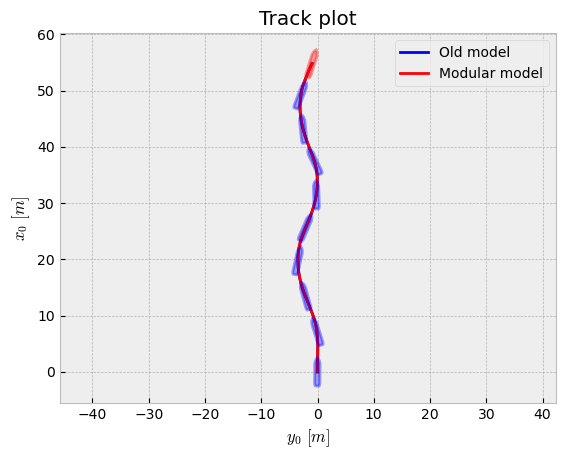

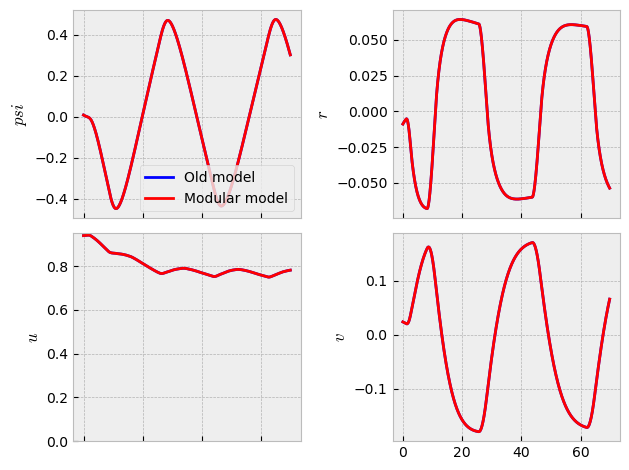

In [68]:
result_with_measured_thrust = model.simulate(data)

dataframes = {
              'Old model':result_old.result,
              'Modular model':result.result,
             }
track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], N=10)
plot(dataframes, keys=['u','v','r','psi']);

In [69]:
sp.simplify(model.acceleartion_eq)

Matrix([
[                                                                                                                                                                                        (-X_D - m*r*(r*x_G + v))/(X_{\dot{u}} - m)],
[(-(I_z - N_{\dot{r}})*(Y_D - m*r*u) - (N_D - m*r*u*x_G)*(Y_{\dot{r}} - m*x_G))/(I_z*Y_{\dot{v}} - I_z*m - N_{\dot{r}}*Y_{\dot{v}} + N_{\dot{r}}*m + N_{\dot{v}}*Y_{\dot{r}} - N_{\dot{v}}*m*x_G - Y_{\dot{r}}*m*x_G + m**2*x_G**2)],
[   ((N_D - m*r*u*x_G)*(Y_{\dot{v}} - m) - (N_{\dot{v}} - m*x_G)*(Y_D - m*r*u))/(I_z*Y_{\dot{v}} - I_z*m - N_{\dot{r}}*Y_{\dot{v}} + N_{\dot{r}}*m + N_{\dot{v}}*Y_{\dot{r}} - N_{\dot{v}}*m*x_G - Y_{\dot{r}}*m*x_G + m**2*x_G**2)]])

In [70]:
model.acceleartion_eq_SI

Matrix([
[                                                                                                                                                                                                                                                                           2*(-X_D - m*r*(r*x_G + v))/(L**3*X_{\dot{u}}*rho - 2*m)],
[2*(-(2*I_z - L**5*N_{\dot{r}}*rho)*(Y_D - m*r*u) - (N_D - m*r*u*x_G)*(L**4*Y_{\dot{r}}*rho - 2*m*x_G))/(2*I_z*L**3*Y_{\dot{v}}*rho - 4*I_z*m - L**8*N_{\dot{r}}*Y_{\dot{v}}*rho**2 + L**8*N_{\dot{v}}*Y_{\dot{r}}*rho**2 + 2*L**5*N_{\dot{r}}*m*rho - 2*L**4*N_{\dot{v}}*m*rho*x_G - 2*L**4*Y_{\dot{r}}*m*rho*x_G + 4*m**2*x_G**2)],
[   2*((N_D - m*r*u*x_G)*(L**3*Y_{\dot{v}}*rho - 2*m) - (Y_D - m*r*u)*(L**4*N_{\dot{v}}*rho - 2*m*x_G))/(2*I_z*L**3*Y_{\dot{v}}*rho - 4*I_z*m - L**8*N_{\dot{r}}*Y_{\dot{v}}*rho**2 + L**8*N_{\dot{v}}*Y_{\dot{r}}*rho**2 + 2*L**5*N_{\dot{r}}*m*rho - 2*L**4*N_{\dot{v}}*m*rho*x_G - 2*L**4*Y_{\dot{r}}*m*rho*x_G + 4*m**2*x_G**2)]])